In [13]:
import glob

import pandas as pd
from tqdm import tqdm
# from rapidfuzz import process, fuzz
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pyreadr
import icd10
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
harmonized_fname = 'harmonized_open_target.csv'

In [53]:
# Load the ICD-10 dataset
df_icd = pd.read_csv("data/DiagAll_Eng.csv")
df_icd['ShortDescription'] = df_icd['ShortDescription'].replace(
    "Dementia in Alzheimer\'s disease", "Dementia"
)
df_icd = df_icd.drop_duplicates(subset=["ShortDescription"])  # Ensure unique descriptions
icd_dict = dict(zip(df_icd["ShortDescription"], df_icd["Code"]))
icd_dict = {k.replace("\"", ""): v for k, v in icd_dict.items()}
icd_dict['Dementia in Alzheimer\'s disease'] = 'F00'
icd_descriptions = list(icd_dict.keys())
icd_codes = list(icd_dict.values())

In [15]:
# open_target_df = pd.read_csv('../CTD/data/open_targets/cor_matrix_95_nolit.csv')
# open_target_df = pd.read_csv('../CTD/data/target_disease/cor_matrix_99.csv.csv')
open_target_df = pd.read_csv('data/open_targets_25_09/dis_dis_nolit_25_09.csv')
open_target_df.index = open_target_df.columns
open_target_df
# for col in open_target_df.columns:
#     if 'ementia' in col:
#         print(col)

,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,3-4 toe syndactyly,...,xeroderma pigmentosum group G,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease
15q overgrowth syndrome,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.038842,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
"17,20-lyase deficiency, isolated",0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined complete",0.0,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2-3 finger syndactyly,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.064783,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young-onset Parkinson disease,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.036001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
zebra body myopathy,0.0,0.0,0.0,0.0,0.064783,0.0,0.0,0.0,0.0,0.0,...,0.020860,0.0,0.0,0.0,0.0,0.0,0.000000,0.027137,0.0,0.0
"zinc deficiency, transient neonatal",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.027137,0.000000,0.0,0.0
zygodactyly type 3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [16]:
# # Add one umbrella for all dementia related diseases
# # Identify columns/rows related to 'dementia' or 'alzheimer' (case-insensitive)
# disease_mask = open_target_df.columns.str.contains('dementia', case=False, regex=True)  # |alzheimer
# selected_diseases = open_target_df.columns[disease_mask]

# # Compute the mean correlation of the selected diseases with all diseases
# merged_row = open_target_df.loc[selected_diseases].mean()
# merged_col = open_target_df[selected_diseases].mean(axis=1)

# # Add the new row and column to the DataFrame
# open_target_df["Dementia in Alzheimer's disease"] = merged_col
# open_target_df.loc["Dementia in Alzheimer's disease"] = list(merged_row) + [0.0]  # correlation with itself
# open_target_df

# Map OpenTargets disease names to ICD10 codes

In [17]:
# Precompute disease embeddings
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

# with open('../CTD/data/open_targets/cor_matrix_95_nolit.csv', 'r') as f:
#     diseases = f.readline().strip().split(',')
diseases = open_target_df.columns  #[d.replace("_", " ").lower() for d in open_target_df.columns]


# Load a pre-trained sentence transformer model
model = SentenceTransformer("NeuML/pubmedbert-base-embeddings")

print('Creating ICD10 embeddings...')
# Encode ICD-10 descriptions as embeddings without converting to tensor
icd_embeddings = model.encode(icd_descriptions, convert_to_tensor=False)

print('Precompute disease embeddings...')
disease_embeddings = {disease: model.encode(disease, convert_to_tensor=False) for disease in diseases}


Creating ICD10 embeddings...
Precompute disease embeddings...


In [18]:
def map_diseases(disease_name_1, disease_embedding, icd_dict, icd_descriptions, icd_codes, icd_embeddings):
#     disease_name_1_cleaned = disease_name_1.replace("_", " ").lower()
    
    # Check for exact match first
    if disease_name_1 in icd_dict:
        return disease_name_1
    
    # If no exact match, use semantic similarity
    disease_embedding_tensor = torch.tensor(disease_embedding)  # Ensure it's a tensor
    icd_embeddings_tensor = torch.tensor(icd_embeddings)  # Convert stored embeddings
    
    similarities = util.pytorch_cos_sim(disease_embedding_tensor, icd_embeddings_tensor)[0]
    best_match_idx = similarities.argmax().item()
    return icd_descriptions[best_match_idx] if similarities[best_match_idx] > 0.5 else "UNKNOWN"

# Map diseases to ICD-10 codes with progress tracking
diseases_mapping = {}
for disease in tqdm(diseases, desc="Mapping disease names to ICD-10"):
    diseases_mapping[disease] = map_diseases(disease, disease_embeddings[disease], icd_dict, icd_descriptions, icd_codes, icd_embeddings)

# Print a sample output
# Print each mapping on a new line
for disease, icd in list(diseases_mapping.items())[:50]:
    print(f"{disease}: {icd}")

Mapping disease names to ICD-10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13370/13370 [00:05<00:00, 2314.67it/s]

15q overgrowth syndrome: UNKNOWN
17,20-lyase deficiency, isolated: UNKNOWN
17-alpha-hydroxylase/17,20-lyase deficiency, combined complete: UNKNOWN
17-alpha-hydroxylase/17,20-lyase deficiency, combined partial: UNKNOWN
2-3 finger syndactyly: Acquired deformities of fingers and toes
2-3 toe syndactyly: Acquired deformities of fingers and toes
2-aminoadipic 2-oxoadipic aciduria: UNKNOWN
2-hydroxyglutaric aciduria: UNKNOWN
2-methylbutyryl-CoA dehydrogenase deficiency: Disorders of branched-chain amino-acid metabolism and fatty-acid metabolism
3-4 toe syndactyly: Acquired deformities of fingers and toes
3-M syndrome: UNKNOWN
3-Methylglutaric aciduria: Disorders of branched-chain amino-acid metabolism and fatty-acid metabolism
3-hydroxy-3-methylglutaric aciduria: UNKNOWN
3-hydroxy-3-methylglutaryl-CoA synthase deficiency: UNKNOWN
3-hydroxyacyl-CoA dehydrogenase deficiency: UNKNOWN
3-hydroxyisobutyric aciduria: UNKNOWN
3-hydroxyisobutyryl-CoA hydrolase deficiency: UNKNOWN
3-methylcrotonyl-CoA

In [19]:
# Assume open_target_df is your large adjacency matrix and diseases_mapping is your dictionary
# Filter columns based on diseases_mapping values that are not 'UNKNOWN'
print("Filtering columns based on valid diseases (not 'UNKNOWN')...")
valid_diseases = {k: v for k, v in diseases_mapping.items() if v != 'UNKNOWN'}

# Ensure only valid keys are used for filtering
valid_keys = set(valid_diseases.keys()) & set(open_target_df.columns)
print(f"Selecting {len(valid_keys)} valid diseases from the matrix...")
filtered_open_target_df = open_target_df.loc[list(valid_keys), list(valid_keys)]

# Rename only the columns and rows that exist in the mapping
rename_mapping = {k: v for k, v in valid_diseases.items() if k in filtered_open_target_df.columns}
print("Renaming rows and columns according to diseases_mapping...")
filtered_open_target_df = filtered_open_target_df.rename(index=rename_mapping, columns=rename_mapping)
print("Matrix shape:", filtered_open_target_df.shape)
# Check for duplicated column names after renaming
# print("Checking for duplicated column names...")
duplicated_columns = filtered_open_target_df.columns[filtered_open_target_df.columns.duplicated()]

# Process each set of duplicated columns
if len(duplicated_columns) > 0:
#     print(f"Warning: Found duplicate column names after renaming: {duplicated_columns.tolist()}")
    
    # Loop through each duplicated column group
    for col in duplicated_columns.unique():
#         print(f"Processing duplicated columns for: {col}...")
        cols_to_mean = filtered_open_target_df.loc[:, filtered_open_target_df.columns == col]
        rows_to_mean = filtered_open_target_df.loc[filtered_open_target_df.index == col, :]

        if cols_to_mean.shape[1] > 1:
            # Compute the mean of the duplicated columns
#             print(f"Averaging the duplicated columns: {cols_to_mean.columns.tolist()}...")
            
            cols_to_mean = filtered_open_target_df.loc[:, filtered_open_target_df.columns == col]
            filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)
            rows_to_mean = filtered_open_target_df.loc[filtered_open_target_df.index == col, :]
            filtered_open_target_df.loc[col + '_temp', :] = rows_to_mean.max(axis=0)
            filtered_open_target_df = filtered_open_target_df.drop(index=rows_to_mean.index[1:])
            filtered_open_target_df = filtered_open_target_df.drop(columns=cols_to_mean.columns[1:])
            filtered_open_target_df.rename(index={col + '_temp' : col}, inplace=True)
            filtered_open_target_df.rename(columns={col + '_temp' : col}, inplace=True)
            
            print("New matrix shape:", filtered_open_target_df.shape)
                

# Display or save the transformed matrix
print("Transformation completed. New matrix shape:", filtered_open_target_df.shape)  # To check the new dimensions

Filtering columns based on valid diseases (not 'UNKNOWN')...
Selecting 8016 valid diseases from the matrix...
Renaming rows and columns according to diseases_mapping...
Matrix shape: (8016, 8016)
New matrix shape: (7957, 7957)
New matrix shape: (7829, 7829)
New matrix shape: (7779, 7779)
New matrix shape: (7733, 7733)
New matrix shape: (7727, 7727)
New matrix shape: (7686, 7686)
New matrix shape: (7642, 7642)
New matrix shape: (7566, 7566)
New matrix shape: (7540, 7540)
New matrix shape: (7378, 7378)
New matrix shape: (7092, 7092)
New matrix shape: (7030, 7030)
New matrix shape: (7017, 7017)
New matrix shape: (6984, 6984)
New matrix shape: (6974, 6974)
New matrix shape: (6956, 6956)
New matrix shape: (6938, 6938)
New matrix shape: (6908, 6908)
New matrix shape: (6889, 6889)
New matrix shape: (6753, 6753)
New matrix shape: (6728, 6728)
New matrix shape: (6691, 6691)
New matrix shape: (6468, 6468)
New matrix shape: (6399, 6399)
New matrix shape: (6310, 6310)
New matrix shape: (6266, 6266

/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4243, 4243)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4227, 4227)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4214, 4214)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4200, 4200)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4185, 4185)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4160, 4160)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4153, 4153)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4140, 4140)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4133, 4133)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4104, 4104)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4088, 4088)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4083, 4083)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4064, 4064)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4049, 4049)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4019, 4019)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4010, 4010)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3981, 3981)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3977, 3977)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3968, 3968)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3957, 3957)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3949, 3949)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3932, 3932)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3924, 3924)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3913, 3913)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3896, 3896)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3884, 3884)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3874, 3874)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3850, 3850)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3832, 3832)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3825, 3825)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3792, 3792)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3762, 3762)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3748, 3748)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3730, 3730)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3717, 3717)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3708, 3708)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3686, 3686)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3676, 3676)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3649, 3649)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3630, 3630)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3616, 3616)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3602, 3602)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3597, 3597)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3574, 3574)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3550, 3550)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3542, 3542)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3520, 3520)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3494, 3494)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3480, 3480)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3457, 3457)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3419, 3419)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3405, 3405)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3391, 3391)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3389, 3389)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3382, 3382)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3377, 3377)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3367, 3367)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3354, 3354)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3347, 3347)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3343, 3343)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3332, 3332)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3310, 3310)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3302, 3302)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3289, 3289)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3287, 3287)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3277, 3277)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3265, 3265)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3253, 3253)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3237, 3237)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3225, 3225)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3222, 3222)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3217, 3217)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3181, 3181)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3176, 3176)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3153, 3153)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3147, 3147)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3141, 3141)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3127, 3127)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3109, 3109)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3095, 3095)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3072, 3072)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3058, 3058)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3048, 3048)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3036, 3036)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3022, 3022)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3014, 3014)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2993, 2993)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2992, 2992)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2975, 2975)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2973, 2973)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2969, 2969)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2962, 2962)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2954, 2954)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2942, 2942)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2936, 2936)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2923, 2923)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2909, 2909)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2878, 2878)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2869, 2869)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2851, 2851)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2836, 2836)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2825, 2825)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2817, 2817)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2813, 2813)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2809, 2809)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2787, 2787)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2775, 2775)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2763, 2763)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2753, 2753)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2743, 2743)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2738, 2738)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2736, 2736)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2727, 2727)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2721, 2721)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2715, 2715)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2714, 2714)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2708, 2708)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2682, 2682)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2677, 2677)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2667, 2667)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2662, 2662)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2635, 2635)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2631, 2631)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2607, 2607)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2606, 2606)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2603, 2603)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2593, 2593)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2581, 2581)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2572, 2572)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2562, 2562)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2552, 2552)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2545, 2545)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2533, 2533)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2519, 2519)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2513, 2513)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2493, 2493)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2485, 2485)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2478, 2478)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2471, 2471)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2457, 2457)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2446, 2446)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2440, 2440)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2430, 2430)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2421, 2421)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2415, 2415)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2405, 2405)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2399, 2399)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2390, 2390)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2377, 2377)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2364, 2364)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2356, 2356)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2348, 2348)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2330, 2330)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2310, 2310)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2304, 2304)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2302, 2302)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2293, 2293)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2289, 2289)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2279, 2279)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2272, 2272)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2263, 2263)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2260, 2260)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2243, 2243)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2238, 2238)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2235, 2235)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2223, 2223)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2214, 2214)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2206, 2206)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2202, 2202)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2197, 2197)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2188, 2188)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2178, 2178)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2167, 2167)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2163, 2163)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2146, 2146)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2137, 2137)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2132, 2132)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2126, 2126)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2121, 2121)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2112, 2112)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2111, 2111)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2079, 2079)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2071, 2071)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2056, 2056)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2055, 2055)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2047, 2047)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2038, 2038)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2032, 2032)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2028, 2028)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2015, 2015)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2014, 2014)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2004, 2004)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2001, 2001)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1993, 1993)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1985, 1985)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1980, 1980)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1973, 1973)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1963, 1963)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1961, 1961)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1960, 1960)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1959, 1959)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1955, 1955)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1946, 1946)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1928, 1928)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1926, 1926)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1906, 1906)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1898, 1898)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1893, 1893)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1885, 1885)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1880, 1880)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1874, 1874)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1872, 1872)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1871, 1871)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1869, 1869)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1868, 1868)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1859, 1859)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1854, 1854)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1845, 1845)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1840, 1840)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1835, 1835)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1834, 1834)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1817, 1817)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1814, 1814)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1812, 1812)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1794, 1794)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1790, 1790)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1780, 1780)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1773, 1773)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1767, 1767)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1763, 1763)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1756, 1756)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1753, 1753)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1750, 1750)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1744, 1744)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1736, 1736)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1731, 1731)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1725, 1725)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1721, 1721)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1714, 1714)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1697, 1697)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1692, 1692)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1690, 1690)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1678, 1678)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1671, 1671)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1664, 1664)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1655, 1655)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1647, 1647)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1641, 1641)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1638, 1638)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1635, 1635)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1631, 1631)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1630, 1630)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1624, 1624)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1620, 1620)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1611, 1611)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1598, 1598)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1591, 1591)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1586, 1586)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1585, 1585)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1580, 1580)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1565, 1565)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1558, 1558)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1549, 1549)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1543, 1543)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1523, 1523)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1520, 1520)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1518, 1518)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1513, 1513)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1506, 1506)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1505, 1505)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1502, 1502)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1499, 1499)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1496, 1496)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1489, 1489)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1482, 1482)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1473, 1473)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1470, 1470)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1469, 1469)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1466, 1466)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1462, 1462)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1456, 1456)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1450, 1450)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1439, 1439)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1434, 1434)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1420, 1420)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1414, 1414)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1413, 1413)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1404, 1404)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1397, 1397)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1389, 1389)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1380, 1380)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1373, 1373)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1369, 1369)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1366, 1366)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1361, 1361)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1357, 1357)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1348, 1348)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1342, 1342)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1336, 1336)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1331, 1331)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1324, 1324)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1321, 1321)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1316, 1316)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1312, 1312)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1308, 1308)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1303, 1303)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1300, 1300)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1298, 1298)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1292, 1292)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1290, 1290)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1286, 1286)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1283, 1283)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1278, 1278)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1270, 1270)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1269, 1269)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1266, 1266)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1260, 1260)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1256, 1256)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1249, 1249)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1244, 1244)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1237, 1237)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1230, 1230)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1225, 1225)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1222, 1222)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1220, 1220)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1217, 1217)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1213, 1213)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1212, 1212)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1207, 1207)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1205, 1205)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1200, 1200)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1194, 1194)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1192, 1192)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1190, 1190)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1188, 1188)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1186, 1186)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1183, 1183)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1182, 1182)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1177, 1177)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1173, 1173)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1169, 1169)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1166, 1166)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1164, 1164)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1161, 1161)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1158, 1158)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1154, 1154)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1150, 1150)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1146, 1146)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1143, 1143)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1140, 1140)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1137, 1137)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1136, 1136)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1135, 1135)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1133, 1133)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1128, 1128)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1127, 1127)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1125, 1125)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1121, 1121)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1119, 1119)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1118, 1118)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1113, 1113)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1110, 1110)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1102, 1102)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1101, 1101)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1096, 1096)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1090, 1090)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1089, 1089)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1088, 1088)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1086, 1086)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1084, 1084)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1083, 1083)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1079, 1079)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1072, 1072)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1069, 1069)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1068, 1068)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1063, 1063)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1058, 1058)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1057, 1057)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1054, 1054)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1050, 1050)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1049, 1049)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1048, 1048)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1047, 1047)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1046, 1046)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1045, 1045)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1042, 1042)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1040, 1040)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1037, 1037)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1035, 1035)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1034, 1034)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1031, 1031)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1028, 1028)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1027, 1027)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1024, 1024)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1022, 1022)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1021, 1021)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1015, 1015)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1011, 1011)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1007, 1007)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1002, 1002)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1001, 1001)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (999, 999)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (998, 998)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (996, 996)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (995, 995)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (993, 993)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (991, 991)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (988, 988)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (982, 982)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (980, 980)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (979, 979)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (977, 977)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (971, 971)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (968, 968)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (967, 967)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (962, 962)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (959, 959)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (956, 956)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (954, 954)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (952, 952)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (949, 949)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (947, 947)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (944, 944)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (942, 942)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (936, 936)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (932, 932)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (927, 927)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (926, 926)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (920, 920)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (918, 918)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (913, 913)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (908, 908)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (907, 907)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (905, 905)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (904, 904)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (902, 902)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (900, 900)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (899, 899)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (897, 897)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (896, 896)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (892, 892)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (890, 890)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (889, 889)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (885, 885)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (882, 882)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (877, 877)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (876, 876)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (875, 875)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (872, 872)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (870, 870)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (869, 869)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (867, 867)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (866, 866)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (865, 865)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (864, 864)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (860, 860)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (858, 858)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (857, 857)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (854, 854)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (852, 852)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (850, 850)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (849, 849)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (848, 848)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (847, 847)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (845, 845)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (844, 844)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (843, 843)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (841, 841)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (840, 840)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (838, 838)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (837, 837)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (835, 835)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (833, 833)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (832, 832)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (831, 831)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (830, 830)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (829, 829)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (828, 828)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (826, 826)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (825, 825)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (823, 823)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (822, 822)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (821, 821)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (820, 820)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (819, 819)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (818, 818)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (817, 817)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (815, 815)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (814, 814)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (813, 813)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (812, 812)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (811, 811)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (810, 810)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (809, 809)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (808, 808)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (807, 807)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (806, 806)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (805, 805)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (803, 803)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (802, 802)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (801, 801)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (800, 800)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (799, 799)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (798, 798)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (797, 797)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (796, 796)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (795, 795)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (794, 794)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (793, 793)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (792, 792)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (790, 790)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (789, 789)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (788, 788)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (787, 787)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (785, 785)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (783, 783)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (782, 782)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (781, 781)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (780, 780)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (779, 779)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_60150/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (778, 778)
Transformation completed. New matrix shape: (778, 778)


In [20]:
for disease, icd in list(diseases_mapping.items()):
    if ('ementia' in disease) or ('lzheimer' in disease):
        print(f"{disease}: {icd}")

AIDS dementia: Dementia
Alzheimer disease: Alzheimer's disease
Alzheimer disease 18: Alzheimer's disease
Alzheimer disease 3: Alzheimer's disease
Alzheimer disease type 1: Alzheimer's disease
Alzheimer's disease neuropathologic change: Alzheimer's disease
Dementia: Dementia
Frontotemporal dementia: Dementia
Lewy body dementia: Parkinson's disease
age of onset of Alzheimer disease: Alzheimer's disease
amyotrophic lateral sclerosis 26 with or without frontotemporal dementia: Vascular dementia
amyotrophic lateral sclerosis-parkinsonism-dementia complex: Parkinson's disease
behavioral variant of frontotemporal dementia: Dementia
dementia: Dementia
early-onset autosomal dominant Alzheimer disease: Alzheimer's disease
familial Alzheimer disease: Alzheimer's disease
family history of Alzheimer’s disease: Alzheimer's disease
frontotemporal dementia: Dementia
frontotemporal dementia and/or amyotrophic lateral sclerosis: Vascular dementia
frontotemporal dementia and/or amyotrophic lateral sclero

In [31]:
harmonized_open_targets = filtered_open_target_df.copy() # List of relevant rows/columns

# Generate matrix with ICD10 codes
# Validate and filter out diseases that cannot be mapped to ICD codes
valid_cols = [col for col in harmonized_open_targets.columns if col in icd_dict]
if len(valid_cols) != len(harmonized_open_targets.columns):
    unmapped_count = len(harmonized_open_targets.columns) - len(valid_cols)
    print(f"Filtering {unmapped_count} unmapped diseases")
    unmapped = [col for col in harmonized_open_targets.columns if col not in icd_dict]
    print(f"Unmapped diseases: {unmapped[:10]}")  # Show first 10
    harmonized_open_targets = harmonized_open_targets.loc[valid_cols, valid_cols]
    
harmonized_open_targets.rename(index={'Dementia': 'Dementia in Alzheimer\'s disease'}, inplace=True)
harmonized_open_targets.rename(columns={'Dementia': 'Dementia in Alzheimer\'s disease'}, inplace=True)
# ['F00', 'F01', 'F02', 'F03', 'G31']
target_labels = ['Dementia in Alzheimer\'s disease', 'Vascular dementia', 
#                  'Dementia in other diseases classified elsewhere', 
#                  'Unspecified dementia',
                 'Alzheimer\'s disease']

# Apply OR operation across specified rows and columns
row_or = harmonized_open_targets.loc[target_labels].max(axis=0).astype(float)
# col_or = filtered_open_target_df[target_labels].any(axis=1)

# Update the 'F00' row and column
harmonized_open_targets.loc['Dementia in Alzheimer\'s disease'] = row_or
harmonized_open_targets['Dementia in Alzheimer\'s disease'] = row_or

In [32]:
# Write to file
harmonized_open_targets.to_csv(harmonized_fname, index=False)
# Now map to ICD codes
harmonized_open_targets.columns = [icd_dict[x] for x in harmonized_open_targets.columns]
harmonized_open_targets.to_csv(harmonized_fname.replace('.csv', '_icd.csv'), index=False)

Percentage of zeros: 25.58%


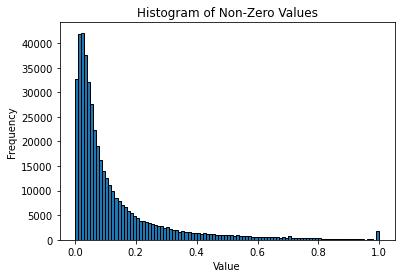

In [33]:
# Flatten DataFrame values to 1D array
all_values = harmonized_open_targets.values.flatten()

# Count zeros and non-zeros
total_values = len(all_values)
zero_count = np.count_nonzero(all_values == 0)
non_zero_values = all_values[all_values != 0]

# Calculate percentage of zeros
zero_percentage = (zero_count / total_values) * 100
print(f"Percentage of zeros: {zero_percentage:.2f}%")

# Plot histogram of non-zero values
plt.hist(non_zero_values, bins=100, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Values')
plt.show()

# Merge with hospital data

In [34]:
diag_df = pd.read_csv('data/Diagnosis_global_10years.csv')  # Read diagnosis metadata  DiagAll_Eng.csv
diag_df = diag_df[diag_df['age_id'] < 9].iloc[:1080, :]
# Add an 'ID' column to diag_df starting from 0 up to the number of rows in diag_df
diag_df['ID'] = range(0, len(diag_df))
diag_df.loc[:, 'English description'] = [icd10.find(x[0]).description if icd10.find(x[0]) else x[1] for x in diag_df[['icd_code', 'descr']].values ]
diag_df.loc[:, 'icd_global'] = diag_df['icd_global'].str.replace('__', '-')
diag_df

,Unnamed: 0,diagnose_id,icd_code,descr,postion,age_id,age_range,icd_global,ID,English description
0,1,1,A00,Cholera,1,1,0-9,A00-0-9,0,Cholera
1,2,2,A01,Typhus abdominalis und Paratyphus,2,1,0-9,A01-0-9,1,Typhoid and paratyphoid fevers
2,3,3,A02,Sonstige Salmonelleninfektionen,3,1,0-9,A02-0-9,2,Other salmonella infections
3,4,4,A03,Shigellose [Bakterielle Ruhr],4,1,0-9,A03-0-9,3,Shigellosis
4,5,5,A04,Sonstige bakterielle Darminfektionen,5,1,0-9,A04-0-9,4,Other bacterial intestinal infections
...,...,...,...,...,...,...,...,...,...,...
1075,1076,1070,N95,Klimakterische Störungen,1076,1,0-9,N95-0-9,1075,Menopausal and other perimenopausal disorders
1076,1077,1071,N96,"Neigung zu habituellem Abort, Infertilität, Un...",1077,1,0-9,N96-0-9,1076,Recurrent pregnancy loss
1077,1078,1072,N97,Sterilität der Frau,1078,1,0-9,N97-0-9,1077,Female infertility
1078,1079,1073,N98,Komplikationen im Zusammenhang mit künstlicher...,1079,1,0-9,N98-0-9,1078,Complications associated with artificial ferti...


In [35]:
open_target_df = pd.read_csv(harmonized_fname.replace('.csv', '_icd.csv'))
open_target_df.index = open_target_df.columns
# open_target_df = (open_target_df > 0).astype(int)
display(open_target_df)

,A64,F05,B98,A27,N01,F45,K42,D43,K03,H73,...,D62,G95,A66,J03,B30,E86,L92,B74,A71,C19
A64,0.000000,0.000000,0.000680,0.000000,0.000000,0.000000,0.013362,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001423,0.015605,0.000000,0.014871,0.007353,0.000000,0.000000,0.000000
F05,0.000000,0.000000,0.012022,0.000000,0.000000,0.085709,0.000000,0.002623,0.000000,0.037839,...,0.168220,0.282591,0.000000,0.221604,0.076241,0.002637,0.000000,0.000000,0.021587,0.002410
B98,0.000680,0.012022,0.000000,0.020556,0.000000,0.000000,0.000000,0.017574,0.000000,0.000000,...,0.002064,0.000000,0.032345,0.040856,0.094090,0.002600,0.000000,0.000000,0.000000,0.000000
A27,0.000000,0.000000,0.020556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.208061,0.023624,0.184515,0.000000,0.039448,0.000000,0.000000,0.000000
N01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014551,0.005985,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026279,0.012718,0.108490,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E86,0.014871,0.002637,0.002600,0.000000,0.026279,0.000000,0.050295,0.107263,0.000000,0.010704,...,0.015674,0.006176,0.000000,0.033612,0.000000,0.000000,0.062795,0.001040,0.043632,0.003518
L92,0.007353,0.000000,0.000000,0.039448,0.012718,0.000000,0.015624,0.136129,0.000266,0.002752,...,0.001398,0.000000,0.032551,0.049454,0.007074,0.062795,0.000000,0.062839,0.046632,0.099529
B74,0.000000,0.000000,0.000000,0.000000,0.108490,0.000000,0.019516,0.009782,0.000000,0.000000,...,0.035199,0.000000,0.000000,0.051726,0.000000,0.001040,0.062839,0.000000,0.000000,0.019209
A71,0.000000,0.021587,0.000000,0.000000,0.000000,0.000000,0.000000,0.067171,0.000000,0.000000,...,0.100745,0.000000,0.000000,0.127624,0.056032,0.043632,0.046632,0.000000,0.000000,0.022689


In [36]:
import time
import random
from Bio import Entrez
from urllib.error import HTTPError

Entrez.email = "your_email@example.com"

# Function to search PubMed with retries
def search_pubmed_with_retry(disease1, disease2, max_results=20_000, retries=5, delay=0.5):
    query = f"{disease1} AND {disease2}"
    
    for attempt in range(retries):
        try:
            handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
            record = Entrez.read(handle)
            handle.close()
            num_articles = len(record["IdList"])
#             print(f"🔍 {disease1}: Found {num_articles} articles.")
            return num_articles
        
        except HTTPError as e:
            print(f"⚠️ HTTPError for query '{query}': {e}. Retrying in {delay} seconds...")
        except Exception as e:
            print(f"⚠️ Unexpected error for query '{query}': {e}. Retrying in {delay} seconds...")
        
        time.sleep(delay)
        delay *= 2  # Exponential backoff
    
    print(f"❌ Failed to fetch results for '{query}' after {retries} retries.")
    
pubmed_cache = {}

def get_pubmed_count_cached(disease1, disease2):
    key = (disease1.lower(), disease2.lower())
    if key not in pubmed_cache:
        pubmed_cache[key] = search_pubmed_with_retry(disease1, disease2)
    return pubmed_cache[key]


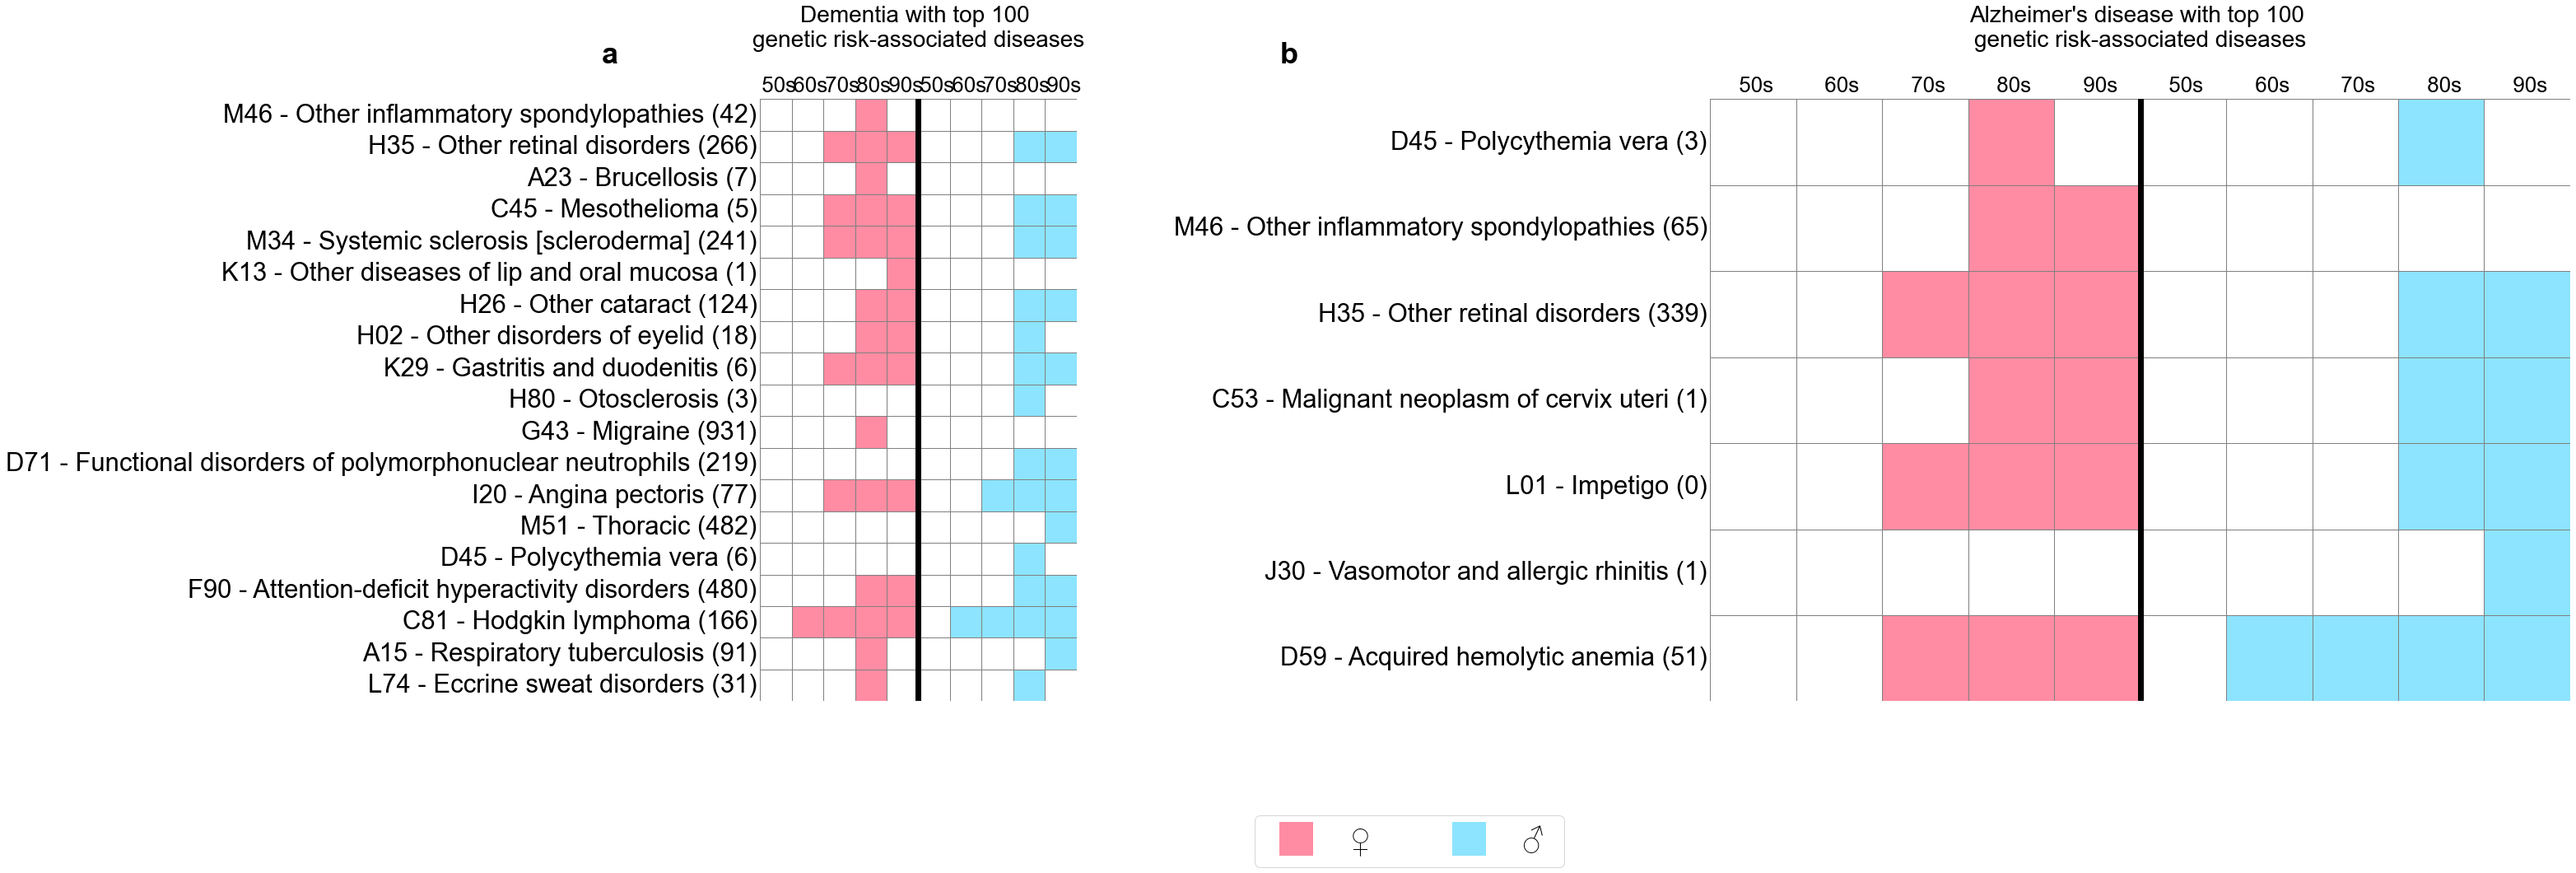

In [65]:
dementia_codes = {'F00': 'Dementia', #'Dementia in Alzheimer\'s disease'
                  'F01': 'Vascular dementia',
                  'F02': 'Dementia in other diseases classified elsewhere',
                  'F03': 'Unspecified dementia',
                  'G30': 'Alzheimer\'s disease'}

with open(harmonized_fname, 'r') as f:
    disease_names = f.readline().strip().split(',')
rds_files = glob.glob("data/dementia_age_groups/*.rds")

disease_name_icd10_dict = dict(zip(disease_names, open_target_df.columns))

for TOP_K in [100]:
    fig, axes = plt.subplots(1, 2, figsize=(45, 15))  # 3 columns, 1 row
    for i, code in enumerate(['F00', 'G30']):
#         if code in df.index:
        df_out = pd.DataFrame(columns=['Graph', 'ICD10', 'Correlated disease', 'Num correlated diseases'])
        ind = 0
        for f in rds_files:
            result = pyreadr.read_r(f) # also works for RData
            # result is a dictionary where keys are the name of objects and the values python
            df = result[None] # extract the pandas data frame 
            # dfs[gender].columns = [str(col) for col in df.columns]
            df.fillna(0, inplace=True)
            df.columns = diag_df['icd_code']
            df.index = diag_df['icd_code']
            df = df.loc[df.index.isin(open_target_df.index), df.columns.isin(open_target_df.columns)]
            row1 = open_target_df.loc[code]
            row2 = df.loc[code]

            # Get the indices of the TOP_K largest elements in row1
            top_indices = np.argpartition(row1.values, -TOP_K)[-TOP_K:]
            # Sort those indices by the actual values (optional, to have sorted results)
            top_indices = top_indices[np.argsort(-row1.values[top_indices])]
            top_disease_names = np.array(disease_names)[top_indices]

            # Extract subsets
            row1_subset = row1.values[top_indices]
            row2_subset = row2.values[top_indices]
            try:
                correlated_diseases = top_disease_names[np.nonzero(row2_subset)[0]]
            except TypeError as e:
                correlated_diseases = [] 

            df_out.loc[ind] = [f.split('/')[-1].split('.')[0].replace('All_OR_', ''), code, correlated_diseases, len(correlated_diseases)]
            ind+=1
#         pd.set_option('display.max_colwidth', None)

        gr_dis_dict = dict(zip(df_out['Graph'], df_out['Correlated disease']))

        dis_gr_dict = dict()
        for graph, dis in gr_dis_dict.items():
            for d in dis:
                if d in dis_gr_dict.keys():
                    dis_gr_dict[d].append(graph)
                else:
                    dis_gr_dict[d] = [graph]
        dis_gr_df = pd.DataFrame({(k, ','.join(v)) for k, v in dis_gr_dict.items()}, columns=['Disease', 'Detected in'])
        for gr in sorted(gr_dis_dict.keys()):
            dis_gr_df.loc[:, gr.replace('_Age_', ' ') + '0s'] = dis_gr_df['Detected in'].apply(lambda x: 1 if gr in x else 0)
        dis_gr_df.rename(columns={'Disease': dementia_codes[code]}, inplace=True)

        dis_gr_df = dis_gr_df.drop(columns=['Detected in'])
        dis_gr_df.set_index(dementia_codes[code], inplace=True)
        for col in dis_gr_df.columns:
            if 'Male' in col:
                dis_gr_df.loc[:, col] = dis_gr_df[col].apply(lambda x: (x + 1) if x else x)  # For painting in different color

        # Modify column and index labels to replace "Female" and "Male" with symbols
        dis_gr_df.columns = [la.replace("Female", "").replace("Male", "") for la in dis_gr_df.columns]
        
        # Compute PubMed article counts and modify index labels
        new_index = []
        for disease in dis_gr_df.index:
            cleaned_disease = disease.replace("\"", "")
            pubmed_count = get_pubmed_count_cached(dementia_codes[code], cleaned_disease)
            new_lab = f"{icd_dict[cleaned_disease]} - {cleaned_disease} ({pubmed_count})".replace("\"", "")
            new_index.append(new_lab)

        dis_gr_df.index = new_index
#         dis_gr_df = dis_gr_df.sort_values(by='Detected in', ascending=False)

        # Set font to Arial
        plt.rcParams["font.family"] = "Arial"

        # Custom colormap
        male_female_color = ["#ff8ca3", "#8ce4ff"]
        cmap = sns.color_palette(["white"] + male_female_color) #"#ded8d7"])

        # Plot heatmap
        ax = sns.heatmap(dis_gr_df, cmap=cmap, cbar=False, linewidths=0.5, linecolor='gray', square=True, ax=axes[i])



        # Move x-axis labels to the top
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')

        # Make x-axis labels horizontal and increase font sizes
        ax.tick_params(axis='x', labelrotation=0, labelsize=26)
        ax.tick_params(axis='y', labelsize=31)
        ax.tick_params(axis='both', which='both', length=0) # Remove tick marks
        ax.set_title(f'{dementia_codes[code]} with top {TOP_K} \ngenetic risk-associated diseases\n', size=28)
        
        mid = len(dis_gr_df.columns) //2
        ax.axvline(x=mid, color='black', linewidth=7)

        
        # Add subplot letter labels (a, b, c...)
        label = chr(97 + i)  # 'a' for 0, 'b' for 1, etc.
        ax.text(-0.5, 1.05, f'{label}', transform=ax.transAxes,
                fontsize=36, fontweight='bold', va='bottom', ha='left')
    labels = ['♀ ', '♂ ']

    # Create custom legend handles
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label=labels[i],
               markerfacecolor=male_female_color[i], markersize=42)
        for i in range(2)
    ]

    # Create the legend at the bottom
    plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(-0.35, -0.3),
               ncol=2, frameon=True, fontsize=36)

    # Adjust layout and save to PDF
    plt.tight_layout()
    pos1 = axes[0].get_position()
    pos2 = axes[1].get_position()

    new_y0 = pos1.y0 + pos1.height - pos2.height
    axes[1].set_position([pos2.x0, new_y0, pos2.width, pos2.height])

    plt.savefig(f"dementia_heatmaps_{TOP_K}.pdf", dpi=200, format='pdf', bbox_inches='tight')
    plt.show()

In [58]:
dis_gr_df.index

Index(['D45 - Polycythemia vera (3)',
       'M46 - Other inflammatory spondylopathies (65)',
       'H35 - Other retinal disorders (339)',
       'C53 - Malignant neoplasm of cervix uteri (1)', 'L01 - Impetigo (0)',
       'J30 - Vasomotor and allergic rhinitis (1)',
       'D59 - Acquired hemolytic anemia (51)'],
      dtype='object')

In [66]:
df_out

,Graph,ICD10,Correlated disease,Num correlated diseases
0,Female_Age_9,G30,"[Other inflammatory spondylopathies, Other ret...",5
1,Female_Age_8,G30,"[Polycythemia vera, Other inflammatory spondyl...",6
2,Male_Age_8,G30,"[Polycythemia vera, Other retinal disorders, A...",5
3,Male_Age_9,G30,"[Other retinal disorders, Acquired hemolytic a...",5
4,Male_Age_7,G30,[Acquired hemolytic anemia],1
5,Male_Age_6,G30,[Acquired hemolytic anemia],1
6,Male_Age_5,G30,[],0
7,Female_Age_5,G30,[],0
8,Female_Age_6,G30,[],0
9,Female_Age_7,G30,"[Other retinal disorders, Acquired hemolytic a...",3


In [67]:
dis_gr_df

,50s,60s,70s,80s,90s,50s,60s,70s,80s,90s
D45 - Polycythemia vera (3),0,0,0,1,0,0,0,0,2,0
M46 - Other inflammatory spondylopathies (65),0,0,0,1,1,0,0,0,0,0
H35 - Other retinal disorders (339),0,0,1,1,1,0,0,0,2,2
C53 - Malignant neoplasm of cervix uteri (1),0,0,0,1,1,0,0,0,2,2
L01 - Impetigo (0),0,0,1,1,1,0,0,0,2,2
J30 - Vasomotor and allergic rhinitis (1),0,0,0,0,0,0,0,0,0,2
D59 - Acquired hemolytic anemia (51),0,0,1,1,1,0,2,2,2,2
